In [3]:
import os
import matplotlib.pyplot as plt
from deepcell.utils.plot_utils import (
    create_rgb_image,
    make_outline_overlay,
)
import skimage
from skimage.io import imsave
from skimage import img_as_ubyte

from tissue_preparation import (
    read_image, 
    generate_nuclear_and_membrane,
    crop_out,
    stack_nuclear_and_membrane,
    run_segmentation,
    extract_sc_features,
)

In [2]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [4]:
in_dir = "/fs/scratch/PCON0100/feng1426/temp/Benchmarking_tissue_preparation_data"
out_dir = "/fs/scratch/PCON0100/feng1426/temp/Benchmarking_tissue_preparation_data/out"

## slide 1

### Segmentation

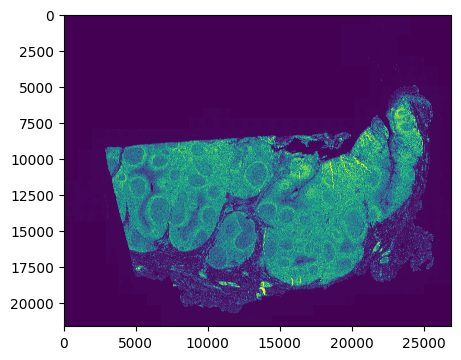

In [5]:
img1 = read_image(f"{in_dir}/Slide 1_20 min HIER 1h RT stain_Scan1.qptiff")
# use this to check which marker is which index in the qptiff
# indexing in python starts at 0 not at 1 like in R, so [0, :, :] = C1 in the qptiff
plt.figure(figsize = (5, 5))
plt.imshow(img1[0, :, :])

Text(0.5, 1.0, 'membrane1')

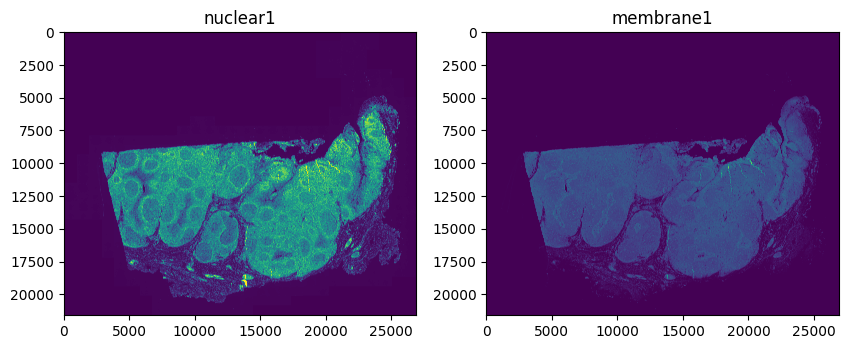

In [6]:
nuclear1, membrane1 = generate_nuclear_and_membrane(img1)
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear1)
ax[1].imshow(membrane1)

ax[0].set_title('nuclear1')
ax[1].set_title('membrane1')

In [7]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave(f"{out_dir}/MESMER_outputs/nuclear1.tiff", nuclear1, check_contrast = False)
imsave(f"{out_dir}/MESMER_outputs/membrane1.tiff", membrane1, check_contrast = False)

In [8]:
stacked_img1 = stack_nuclear_and_membrane(nuclear=nuclear1, membrane=membrane1)

Text(0.5, 1.0, 'cropped1')

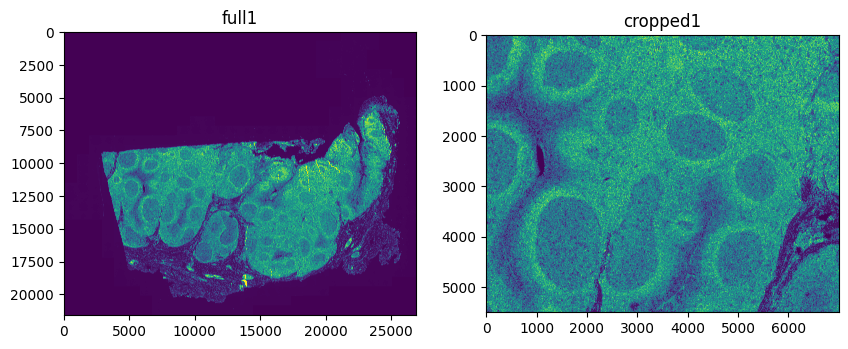

In [9]:
# crop out area of interest
y_min1 = 9500
y_max1 = 15000
x_min1 = 5000
x_max1 = 12000

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stacked_img1[0, :, :, 0])
ax[1].imshow(stacked_img1[0, y_min1:y_max1, x_min1:x_max1, 0])

ax[0].set_title('full1')
ax[1].set_title('cropped1')

In [10]:
cropped_stack1 = crop_out(stacked_img1, xmin=x_min1, xmax=x_max1, ymin=y_min1, ymax=y_max1)
cropped_stack1.shape

(1, 7000, 26880, 2)

In [11]:
# maxima_threshold controls what is considered a unique cell (lower values = more separate cells, higher values = fewer cells)
# interior_threshold determines what is considered background/not part of a cell (lower value = larger cells)
maxima_threshold = 0.075
interior_threshold = 0.2
predictions1 = run_segmentation(img=cropped_stack1, maxima_threshold=maxima_threshold, interior_threshold=interior_threshold)

INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting /users/PCON0100/feng1426/.deepcell/models/MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted /users/PCON0100/feng1426/.deepcell/models/MultiplexSegmentation-9.tar.gz into /users/PCON0100/feng1426/.deepcell/models
2024-08-30 18:03:40.953685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 18:03:41.087812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, nam

2024-08-30 18:04:38.487023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
/users/PCON0100/feng1426/.local/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


In [12]:
rgb_image = create_rgb_image(cropped_stack1, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions1)

# save MESMER outputs
output_dir = f'{out_dir}/MESMER_outputs/{maxima_threshold}maxima_1_{interior_threshold}interior_1/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

skimage.io.imsave(output_dir + "seg_outline1.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(output_dir + "seg_overlay1.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(output_dir + "MESMER_mask1.tiff", predictions1[0, ..., 0], check_contrast = False) # MESMER mask

In [ ]:
### Extract SC features

In [ ]:
data_full1, dataScale_full1 = extract_sc_features(
    img=img1, 
    mesmer_result_fn=out_dir+"MESMER_mask1.tiff",
    xmin=x_min1, ymin=y_min1, xmax=x_max1, ymax=y_max1,
)

In [ ]:
data_full1.head()

In [ ]:
dataScale_full1.head()

In [ ]:
data_full1.to_csv(os.path.join(out_dir, 'data_slide1.csv'), index = False)
dataScale_full1.to_csv(os.path.join(out_dir, 'dataScaleSize_slide1.csv'), index = False)